# Instructions
You will submit an HTML document to Canvas as your final version.

Your document should show your code chunks/cells as well as any output. Make sure that only relevant output is printed. Do not, for example, print the entire dataset in your final rendered file.

Your document should also be clearly organized, so that it is easy for a reader to find your answers to each question.

# The Data
This week, we consider a dataset generated from text data.

The original dataset can be found here: https://www.kaggle.com/datasets/kingburrito666/cannabis-strains. It consists of user reviews of different strains of cannabis. Users rated their experience with the cannabis strain on a scale of 1 to 5. They also selected words from a long list to describe the Effects and the Flavor of the cannabis.

In the dataset linked above, each row is one strain of cannabis. The average rating of all testers is reported, as well as the most commonly used words for the effect and flavor.

Some data cleaning has been performed for you: The Effect and Flavor columns have been converted to dummy variables indicating if the particular word was used for the particular strain.

This cleaned data can be found at: https://www.dropbox.com/s/s2a1uoiegitupjc/cannabis_full.csv

Our goal will be to fit models that identify the Sativa types from the Indica types, and then to fit models that also distinguish the Hybrid types.

**IMPORTANT**: In this assignment, you do not need to consider different feature sets. Normally, this would be a good thing to try - but for this homework, simply include all the predictors for every model.


In [3]:
import pandas as pd

can = pd.read_csv("/Users/dan/calpoly/BusinessAnalytics/GSB544MACHINE/Week9/data/cannabis_full.csv")
can.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



# Part One: Binary Classification
Create a dataset that is limited only to the Sativa and Indica type cannabis strains.

This section asks you to create a final best model for each of the four new model types studied this week: LDA, QDA, SVC, and SVM. For SVM, you may limit yourself to only the polynomial kernel.

For each, you should:

- Choose a metric you will use to select your model, and briefly justify your choice. *(Hint: There is no specific target category here, so this should not be a metric that only prioritizes one category.)*

- Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

- Report the (cross-validated!) metric.

- Fit the final model.

- Output a confusion matrix.


In this section we will be using F1-Score as our metric. This is because F1-Score balances precision and recall, making it a useful metric when false positives and false negatives matter equally; and in this case we want to classify both strands equally.

In [37]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer, make_column_selector


ct = ColumnTransformer(
  [
    ("impute_cat", SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=object)),
    ("impute_num", SimpleImputer(strategy='mean'), make_column_selector(dtype_include=np.number)),
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

sativa_indica = can[(can['Type'] == 'sativa') | (can['Type'] == 'indica')]
sativa_indica = sativa_indica.dropna()
sativa_indica = sativa_indica.drop(columns="Strain")
sativa_indica["type_binary"] = (sativa_indica["Type"] == "sativa").astype(int)

y = sativa_indica["type_binary"]
X = sativa_indica.drop(columns= ["Type", "type_binary","Effects","Flavor"])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


#### Q1: LDA


In [49]:
pipeline_lda = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'))
])

# Create grid for tuning
lda_params = { 
    'regressor__tol': [1e-4, 1e-3, 1e-2]  # Tolerance for optimization
}

# Perform grid search
lda_grid = GridSearchCV(pipeline_lda, lda_params, cv=5, scoring='f1')
best_lda = lda_grid.fit(X_train, y_train)

y_pred_lda = lda_grid.best_estimator_.predict(X_test)
print(f"Best LDA parameters: {lda_grid.best_params_}")
print(f"\nBest F1 Score: {lda_grid.best_score_}")
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_lda))

Best LDA parameters: {'regressor__tol': 0.0001}

Best F1 Score: 0.8133005431902489

Confusion Matrix:
 [[151  14]
 [ 19  83]]


#### Q2: QDA


In [50]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


pipeline_qda = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', QuadraticDiscriminantAnalysis())
])

# Create grid for tuning
qda_params = {'regressor__reg_param': [0.0, 0.01, 0.1, 0.5]}

# Perform grid search
qda_grid = GridSearchCV(pipeline_qda, qda_params, cv=5, scoring='f1')
best_qda = qda_grid.fit(X_train, y_train)

y_pred_qda = qda_grid.best_estimator_.predict(X_test)
print(f"Best QDA parameters: {qda_grid.best_params_}")
print(f"\nBest F1 Score: {qda_grid.best_score_}")
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_qda))

Best QDA parameters: {'regressor__reg_param': 0.5}

Best F1 Score: 0.7442644212156406

Confusion Matrix:
 [[135  30]
 [ 15  87]]


#### Q3: SVC


In [51]:
pipeline_svc = Pipeline([
    ('preprocessor', ct),
    ('regressor', SVC(probability=True))  # SVC with probability enabled
])

# Create grid for tuning
param_grid = {
    'regressor__C': [0.01, 0.1, 1],  # Regularization parameter
    'regressor__kernel': ['linear', 'rbf'], 
    'regressor__gamma': ['scale', 'auto']
}
# Perform grid search
svc_grid = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring='f1')
best_svc = svc_grid.fit(X_train, y_train)

y_pred_svc = svc_grid.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_grid.best_params_}")
print(f"\nBest F1 Score: {svc_grid.best_score_}")
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_svc))

Best SVC parameters: {'regressor__C': 1, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear'}

Best F1 Score: 0.8060520438282255

Confusion Matrix:
 [[150  15]
 [ 21  81]]


#### Q4: SVM


In [52]:
pipeline_sva = Pipeline([
    ('preprocessor', ct),
    ('regressor', SVC(probability=True, kernel= "poly")) 
])

# Create grid for tuning
param_grid = {'regressor__C': [0.1, 1, 10], 
              'regressor__degree': [2, 3, 4], 
              'regressor__coef0': [0.0, 1.0]
              }

# Perform grid search
sva_grid = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring='f1')
best_sva = sva_grid.fit(X_train, y_train)

y_pred_sva = sva_grid.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {sva_grid.best_params_}")
print(f"\nBest F1 Score: {sva_grid.best_score_}")
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_sva))

Best SVC parameters: {'regressor__C': 1, 'regressor__coef0': 0.0, 'regressor__degree': 2}

Best F1 Score: 0.7776665752933463

Confusion Matrix:
 [[154  11]
 [ 21  81]]


Through our analysis, we found that the Linear Discriminant Analysis model produced the best F1 score. Thus is the best at predicting the strand type.


# Part Two: Natural Multiclass
Now use the full dataset, including the Hybrid strains.


In [55]:
can_drop = can.drop(columns= ["Effects","Flavor", "Strain"])
can_drop_na = can_drop.dropna()
can_drop_na

y = can_drop_na["Type"]
X = can_drop_na.drop(columns= "Type")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)


#### Q1: Fit a decision tree, plot the final fit, and interpret the results.


In [73]:
from sklearn.tree import DecisionTreeClassifier

# Define pipeline for Decision Tree
pipeline_dt = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', DecisionTreeClassifier(random_state=42))
])

# Create grid for tuning
tree_params = {
    'regressor__max_depth': range(1, 5), 
    'regressor__min_samples_split': range(2, 5),
    'regressor__min_samples_leaf': [1, 2, 4],
                }
tree_grid = GridSearchCV(pipeline_dt, tree_params, cv=5, scoring='f1_weighted')
best_tree = tree_grid.fit(X_train, y_train)

print(f"Best Decision Tree parameters: {tree_grid.best_params_}")
print(f"\nBest F1 Score: {tree_grid.best_score_}")

Best Decision Tree parameters: {'regressor__max_depth': 3, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}

Best F1 Score: 0.6228433087130927


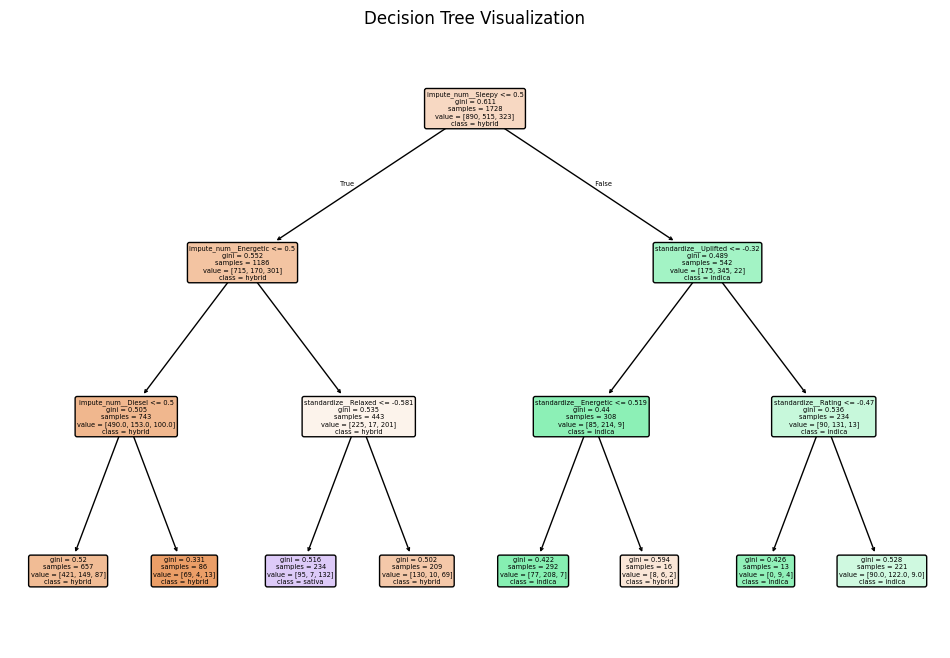

In [71]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the preprocessor from the pipeline
preprocessor = tree_grid.best_estimator_.named_steps['preprocessor']

# Get feature names from the preprocessor
if hasattr(preprocessor, 'get_feature_names_out'):  # Check for compatibility
    feature_names = preprocessor.get_feature_names_out()
else:
    feature_names = X_train.columns  # Fallback if not using transformers
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the best decision tree model
best_dt_model = tree_grid.best_estimator_.named_steps['regressor']

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_dt_model, 
          feature_names=feature_names,  # Use adjusted feature names
          class_names=tree_grid.classes_,  # Automatically fetch class names
          filled=True, 
          rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


Here we see we get a decision tree with 8 leaf nodes, corresponding to an F1 score of 0.6228433087130927. We can see that the model looks for if the strain made the person sleepy or not to first indicate strand. Also we can see that there is only one path leading to a sativa classification, which may be why the score is lower than the last section. 


#### Q2: Repeat the analyses from Part One for LDA, QDA, and KNN.

LDA:

In [66]:
pipeline_lda = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'))
])

# Create grid for tuning
lda_params = { 
    'regressor__tol': [1e-4, 1e-3, 1e-2]  # Tolerance for optimization
}

# Perform grid search
lda_grid = GridSearchCV(pipeline_lda, lda_params, cv=5, scoring='f1_weighted')
best_lda = lda_grid.fit(X_train, y_train)

y_pred_lda = lda_grid.best_estimator_.predict(X_test)
print(f"Best LDA parameters: {lda_grid.best_params_}")
print(f"\nBest F1 Score: {lda_grid.best_score_}")
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_lda))

Best LDA parameters: {'regressor__tol': 0.0001}

Best F1 Score: 0.6279208570506094

Confusion Matrix:
 [[185  55  57]
 [ 50 115   7]
 [ 53   6  49]]


QDA:

In [68]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


pipeline_qda = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', QuadraticDiscriminantAnalysis())
])

# Create grid for tuning
qda_params = {'regressor__reg_param': [0.0, 0.01, 0.1, 0.5]}

# Perform grid search
qda_grid = GridSearchCV(pipeline_qda, qda_params, cv=5, scoring='f1_weighted')
best_qda = qda_grid.fit(X_train, y_train)

y_pred_qda = qda_grid.best_estimator_.predict(X_test)
print(f"Best QDA parameters: {qda_grid.best_params_}")
print(f"\nBest F1 Score: {qda_grid.best_score_}")
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_qda))

Best QDA parameters: {'regressor__reg_param': 0.5}

Best F1 Score: 0.4821340908513546

Confusion Matrix:
 [[105  94  98]
 [ 35 124  13]
 [ 36  16  56]]


KNN: 

In [74]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_KNN = Pipeline(steps=[
    ('preprocessor', ct),
    ('regressor', KNeighborsClassifier())
])
# Create grid for tuning
knn_params = {'regressor__n_neighbors': range(1, 21)}
knn_grid = GridSearchCV(pipeline_KNN, knn_params, cv=5, scoring='f1_weighted')
best_knn = knn_grid.fit(X_train, y_train)

y_pred_knn = knn_grid.best_estimator_.predict(X_test)
print(f"Best KNN parameters: {knn_grid.best_params_}")
print(f"\nBest F1 Score: {knn_grid.best_score_}")
print("\nConfusion Matrix:\n",confusion_matrix(y_test, y_pred_knn))

class_order = np.unique(y_train)  # Replace with y_test if needed

Best KNN parameters: {'regressor__n_neighbors': 19}

Best F1 Score: 0.5492749514234664

Confusion Matrix:
 [[247  36  14]
 [ 91  79   2]
 [ 94   1  13]]



#### Q3: Were your metrics better or worse than in Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?

We found that the metrics were much worse when adding in a third type. This makes sense as `hybrid` is a mix of both `sativa` and `indica`, so misclassification is inevitable. This is reflected in our confusion matrices as well. (key: class0-hybrid, class1-indica, class2- sativa)

- **LDA**:  We see hybrid being classified the most and having the most misclassifications in the model because of the confusion of hybrid being added to the data frame. 

- **QDA**: Follows a slightly different pattern in having the most correct classifications be for the indica type. However we see again the downfall of the addition of hybris as 192 strains were misclassified as hybrid. 

- **KNN**: Again we see a huge amount of misclassifications. This time 185 strains being classified as non-hybrid when they are. 



# Part Three: Multiclass from Binary
Consider two models designed for binary classification: SVC and Logistic Regression.


#### Q1: Fit and report metrics for OvR versions of the models. That is, for each of the two model types, create three models:


In [77]:
from sklearn.linear_model import LogisticRegression

pipeline_svc = Pipeline([
    ('preprocessor', ct),
    ('regressor', SVC(probability=True))  # SVC with probability enabled
])

# Create grid for tuning
param_grid = {
    'regressor__C': [0.01, 0.1, 1],  # Regularization parameter
    'regressor__kernel': ['linear', 'rbf'], 
    'regressor__gamma': ['scale', 'auto']
}

pipeline_logistic = Pipeline([
    ('preprocessor', ct),
    ('regressor', LogisticRegression(max_iter=1000))
])
# Create grid for tuning
logreg_params = {'regressor__C': [0.01, 0.1, 1, 10, 100]}


- Indica vs. Not Indica


In [84]:
can_drop_na = can_drop_na.copy()
can_drop_na.loc[:, "indica"] = (can_drop_na["Type"] == "indica").astype(int)

X = can_drop_na.drop(columns= ["Type", "indica"])
y = can_drop_na["indica"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# SVC
svc_grid = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring='f1')
best_svc = svc_grid.fit(X_train, y_train)
y_pred_svc = svc_grid.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_grid.best_params_}")
print(f"Best F1 Score: {svc_grid.best_score_}\n")

# Logistic
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='f1')
best_logreg = logreg_grid.fit(X_train, y_train)
print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"Best F1 Score: {logreg_grid.best_score_}")

Best SVC parameters: {'regressor__C': 0.01, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear'}
Best F1 Score: 0.6641331063750833

Best Logistic parameters: {'regressor__C': 10}
Best F1 Score: 0.6607505819568624



- Sativa vs. Not Sativa


In [83]:
can_drop_na = can_drop_na.copy() 
can_drop_na.loc[:, "sativa"] = (can_drop_na["Type"] == "sativa").astype(int)

X = can_drop_na.drop(columns= ["Type", "indica", "sativa"])
y = can_drop_na["sativa"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# SVC
svc_grid = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring='f1')
best_svc = svc_grid.fit(X_train, y_train)
y_pred_svc = svc_grid.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_grid.best_params_}")
print(f"Best F1 Score: {svc_grid.best_score_}\n")

# Logistic
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='f1')
best_logreg = logreg_grid.fit(X_train, y_train)
print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"Best F1 Score: {logreg_grid.best_score_}")

Best SVC parameters: {'regressor__C': 1, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear'}
Best F1 Score: 0.1601410934744268

Best Logistic parameters: {'regressor__C': 1}
Best F1 Score: 0.39034306760080484



- Hybrid vs. Not Hybrid


In [85]:
can_drop_na = can_drop_na.copy()
can_drop_na.loc[:, "hybrid"] = (can_drop_na["Type"] == "hybrid").astype(int)

X = can_drop_na.drop(columns= ["Type", "indica", "sativa", "hybrid"])
y = can_drop_na["hybrid"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# SVC
svc_grid = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring='f1')
best_svc = svc_grid.fit(X_train, y_train)
y_pred_svc = svc_grid.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_grid.best_params_}")
print(f"Best F1 Score: {svc_grid.best_score_}\n")

# Logistic
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='f1')
best_logreg = logreg_grid.fit(X_train, y_train)
print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"Best F1 Score: {logreg_grid.best_score_}")

Best SVC parameters: {'regressor__C': 0.1, 'regressor__gamma': 'scale', 'regressor__kernel': 'rbf'}
Best F1 Score: 0.6897385801075787

Best Logistic parameters: {'regressor__C': 0.01}
Best F1 Score: 0.6384497274147127



#### Q2: Which of the six models did the best job distinguishing the target category from the rest? Which did the worst? Does this make intuitive sense?

Out of the six models the one that performed teh best was SVC with hybrid vs non-hybrid with the two models for indica vs non-indica coming in as very close seconds and sativa vs non-sativa far in last. It made sense that the sativa test would do the worst because looking at the confusion matrices we found before, we saw that there were the least amount of types that were sativa and they were often misclassified. Then, since there were the most hybrid types, it makes sense that the model would perform better as it has much more data to read. Finally, with our close second indica, we can look back at our decision tree to understand why these types were classified correctly. We saw in the tree that if a stain had a `sleepy` effect it would push to the side that predicted indica 75% of the time. Thus, these results make intuitive sense. 

#### Q3: Fit and report metrics for OvO versions of the models. That is, for each of the two model types, create three models:


In [90]:
can_drop_na = can_drop_na.copy()
can_reset = can_drop_na.drop(columns= ["indica", "sativa", "hybrid"])


- Indica vs. Sativa


In [92]:
can_i_s = can_reset[(can_reset["Type"] == "indica") | (can_reset["Type"] == "sativa")]

X = can_i_s.drop(columns= ["Type"])
y = can_i_s["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# SVC
svc_grid = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring='f1_weighted')
best_svc = svc_grid.fit(X_train, y_train)
y_pred_svc = svc_grid.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_grid.best_params_}")
print(f"Best F1 Score: {svc_grid.best_score_}\n")

# Logistic
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='f1_weighted')
best_logreg = logreg_grid.fit(X_train, y_train)
print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"Best F1 Score: {logreg_grid.best_score_}")

Best SVC parameters: {'regressor__C': 0.01, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear'}
Best F1 Score: 0.8352346996076838

Best Logistic parameters: {'regressor__C': 0.1}
Best F1 Score: 0.8380387887257985



- Indica vs. Hybrid


In [93]:
can_i_h = can_reset[(can_reset["Type"] == "indica") | (can_reset["Type"] == "hybrid")]

X = can_i_h.drop(columns= ["Type"])
y = can_i_h["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# SVC
svc_grid = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring='f1_weighted')
best_svc = svc_grid.fit(X_train, y_train)
y_pred_svc = svc_grid.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_grid.best_params_}")
print(f"Best F1 Score: {svc_grid.best_score_}\n")

# Logistic
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='f1_weighted')
best_logreg = logreg_grid.fit(X_train, y_train)
print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"Best F1 Score: {logreg_grid.best_score_}")

Best SVC parameters: {'regressor__C': 0.01, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear'}
Best F1 Score: 0.7532435116993734

Best Logistic parameters: {'regressor__C': 0.1}
Best F1 Score: 0.7450054979651556



- Hybrid vs. Sativa


In [94]:
can_h_s = can_reset[(can_reset["Type"] == "hybrid") | (can_reset["Type"] == "sativa")]

X = can_h_s.drop(columns= ["Type"])
y = can_h_s["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# SVC
svc_grid = GridSearchCV(pipeline_svc, param_grid, cv=5, scoring='f1_weighted')
best_svc = svc_grid.fit(X_train, y_train)
y_pred_svc = svc_grid.best_estimator_.predict(X_test)
print(f"Best SVC parameters: {svc_grid.best_params_}")
print(f"Best F1 Score: {svc_grid.best_score_}\n")

# Logistic
logreg_grid = GridSearchCV(pipeline_logistic, logreg_params, cv=5, scoring='f1_weighted')
best_logreg = logreg_grid.fit(X_train, y_train)
print(f"Best Logistic parameters: {logreg_grid.best_params_}")
print(f"Best F1 Score: {logreg_grid.best_score_}")

Best SVC parameters: {'regressor__C': 1, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear'}
Best F1 Score: 0.7275708083005606

Best Logistic parameters: {'regressor__C': 1}
Best F1 Score: 0.7289286846309435



#### Q4: Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?

Here with no surprise we see that the best models were the ones using sativa vs indica. This makes sense as the two types are the most dissimilar. Then we see that the indica vs hybrid performed second best, potentially due to the difference in the `sleepy` parameter. Finally, the hybris vs sativa performed the worst because the two types have too many similarities. These results make sense as they reflect where there are key differences between the strains. 

#### Q5: Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach?
#### What about for SVC?
*Note: You do not actually have to run code here - you only need to look at sklearn’s documentation to see how these functions handle multiclass input.*


Both Logistic Regression and SVC typically use the One-vs-Rest (OvR) approach for multiclass classification because it's simpler and more efficient when dealing with multiple classes. In this method, for each class, a separate model is created to distinguish that class from all the others. This makes it easier to implement, especially when there are many classes, as it reduces the complexity of creating models for every possible pair of classes. Since OvR is easier to scale and understand, it’s often the default approach for these models.